### LIB

In [ ]:
import os, re, json
import pandas as pd
from collections import defaultdict
from sympy import *

import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad


from scipy.optimize import fsolve
import scipy.special as gamma

import random
random.seed(42)

### FUNC

In [ ]:
def prep_data_fn(data, ruls, mode='VIB'):
  '''
  Data preparation

  group:
  data_prep: cleaned version of a system of items
  text_key: a dictionary of groups (not including individual item)
  main_list: a list of main (top nodes) that will be connected at the last step
  '''

  data_prep = {}
  group = {}
  group_add = defaultdict(list)
  text_key = {}
  main_list = []

  node = data['nodeDataArray']
  for n in node:
    n['key'] = int(n['key'])
    try:
      n['group'] = int(n['group'])
    except:
      print ("no group")

    if 'isGroup' in n:
        rul = 0.1
    else:
        if n['fi01_id']!=0:
            text_mode = f"fi-11-{str(n['fi01_id']).zfill(3)} {n['text']}_{mode}"
        else:
            text_mode = n['text']
        rul = ruls[text_mode]

    dat_add = [n['text'], rul]

    if n['key']>0:
      text_key[n['text']] = n['key']

    if 'isGroup' in n.keys() and 'group' not in n.keys():
      # this node is the main root node of a group (it is not under any group)
      main_list.append(n['key'])
      try:
        data_prep[n['key']] = {'text': n['text'], 'horiz': n['horiz'], 'val': rul}
      except:
        data_prep[n['key']] = {'text': n['text'], 'horiz': False, 'val': rul}

    elif 'isGroup' in n.keys() and 'group' in n.keys():
      # this node has a group under and it is also under another group
      group_add[n['group']].append(n['key'])
      try:
        data_prep[n['key']] = {'text': n['text'], 'group': n['group'], 'horiz': n['horiz'], 'val': rul}
      except:
        data_prep[n['key']] = {'text': n['text'], 'group': n['group'], 'horiz': False, 'val': rul}

    if 'group' in n.keys():
      if n['group'] not in group.keys():
        group[n['group']] = [dat_add]
      else:
        group[n['group']].append(dat_add)

  return group, text_key, data_prep, main_list

def compute_r(val_list, type):

  print ("val_list: ", val_list)
  i=0
  while i<len(val_list):
    val = val_list[i]
    if type == 'series':
      if i==0:
        update_val = val
      else:
        update_val = update_val*val

    else:
      if i==0:
        update_val = 1-val
      else:
        update_val = update_val*(1-val)

    i+=1

  if type == 'parallel':
    update_val = 1-update_val

  return update_val

def process(group, text_key, data_prep):
  d = max(group.keys())
  while d>0:
    print ("d: ", d)
    val_list = []

    if d not in group.keys():
      d-=1
      continue

    for gr in group[d]:
      text = gr[0]
      val = gr[1]
      print (text, val)
      if 'group' in text.lower() or 'main' in text.lower():
          val_list.append(data_prep[text_key[text]]['val'])
      else:
        val_list.append(val)

    if data_prep[d]['horiz']:
      val_update = compute_r(val_list, 'series')
    else:
      val_update = compute_r(val_list, 'parallel')

    data_prep[d]['val'] = val_update

    d-=1

  return data_prep

def process_root(main_list, data_prep):
  # main
  val_list = []
  for d in main_list:
    val_list.append(data_prep[d]['val'])

  r_system = compute_r(val_list, 'series')

  return r_system

#----------------------------------- Minimize Function -----------------------------------#
def random_t(num_points, min_value, max_value):

    data = [random.randint(min_value, max_value) for _ in range(num_points)]

    return (data)

def equation(params, ts):
    alpha, beta = params

    gamma = 0
    n = len(ts)
    ln_alpha = n*np.log(alpha)
    ln_beta = n*np.log(beta)
    sum_ln = sum( np.log((t - gamma) / beta ) for t in ts)
    sum_alpha = sum( ((t - gamma) / beta)**alpha for t in ts)

    L = ln_alpha - ln_beta + (alpha-1)*sum_ln - sum_alpha

    return -L

def residual(params, t_data):
    predicted_values = equation(params, t_data)
    return np.sum(predicted_values**2)

def rul_minimize(t_data):
    #----------------------------------- Minimize -----------------------------------#
    initial_params = [1, 1]
    bnds = ((0.1e-10, None), (0.1e-10, None))

    result = minimize(residual, initial_params, args=(t_data,), bounds=bnds, method='L-BFGS-B')

    #----------------------------------- Result -----------------------------------#
    alpha_optimized, beta_optimized = result.x

    print("Success:", result.success)
    print("Alpha:", alpha_optimized)
    print("Beta:", beta_optimized)
    # print("Minimum Residual:", equation([alpha_optimized, beta_optimized], t_data).min())
    return alpha_optimized, beta_optimized

#----------------------------------- Load -----------------------------------#

def check_use_default(withSD):

    sd = withSD.copy()
    sd = sd['nodeItemArray']
    print('raw data:', sd[0]['Value'])

    # Default
    if 'Value' in sd[0]:
        if len(sd[0]['Value'])!=0:
            return True

    return True

    # sd_mt1 = [ float(i['MT1']) for i in sd if float(i['MT1'])>0]


def solve_from_mean_var(mean_value, variance_value):


    # Define the equations to solve
    def equations(vars):
        k, lambd = vars
        eq1 = lambd * gamma.gamma(1 + 1/k) - mean_value
        eq2 = lambd**2 * (gamma.gamma(1 + 2/k) - (gamma.gamma(1 + 1/k))**2) - variance_value
        return [eq1, eq2]

    # Initial guess for k and lambda
    initial_guess = [1, 1]

    # Solve the equations
    solution = fsolve(equations, initial_guess)

    return solution

#----------------------------------- RUL -----------------------------------#


def cal_rul(a, b, t):
    def integrand(x, a, b):
        return np.exp(-((x / b) ** a))

    # Perform the integration
    R_integrated = quad(integrand, t, np.inf, args=(a, b))

    # Calculate the reliability at time t
    R = np.exp(-((t / b) ** a))

    # Calculate RUL
    RUL = R_integrated[0] / R

    print(f'--> t = {t:.1f}, RUL: {RUL:.1f}, R: {R:.2f}, alpha: {a:.2f}, beta: {b:.2f}')
    return RUL

### MAIN


failIureItemGroup --> บอกว่าต่อยังไง

failIemDetai_withSD --> บอกว่าค่า Reliability เท่าไหร่
ไฟล์ SD1 = default (กรณี user ไม่ใส่ค่ามา)

MT = time to failure --> ใช้เอาไป input ใน RUL
SD = คืออะไรไม่รู้


todo = เชื่อม code ทุกอย่างเข้าด้วยกัน
1. อ่านไฟล์ failIureItemGroup --> หาว่าต่อแบบไหน
2. อ่านไฟล์ withSD
  - ถ้ามาเป็น list ก็เอาเข้า RUL ก่อน
  - ถ้ามาเป็น default ให้เลือก mode_name = ใช้ค่า reliability ต่ำสุด ???
3. คำนวณ R ของระบบ โดยใช้สคริปพี่พิศ

#### Write files

In [ ]:
%%writefile GroupComponent.json
 {
    "class": "go.GraphLinksModel",
    "nodeDataArray": [
        {
            "key": "1",
            "isGroup": true,
            "text": "Main 1",
            "horiz": true
        },
        {
            "key": "2",
            "isGroup": true,
            "text": "Main 2",
            "horiz": true
        },
        {
            "key": "3",
            "isGroup": true,
            "text": "Sub Main A",
            "group": "1"
        },
        {
            "key": "4",
            "isGroup": true,
            "text": "Sub Main B",
            "group": "1"
        },
        {
            "key": "5",
            "isGroup": true,
            "text": "Sub Main C",
            "group": "1"
        },
        {
            "key": "6",
            "isGroup": true,
            "text": " Sub Main D",
            "group": "2"
        },
        {
            "key": "7",
            "isGroup": true,
            "text": " Sub Main E",
            "group": "6"
        },
        {
            "key": -101,
            "group": "1",
            "text": "Compressors-1",
            "fi01_id": 0,
            "com01_id": "1"
        },
        {
            "key": -101,
            "group": "4",
            "text": "Gas Turbines-1",
            "fi01_id": 0,
            "com01_id": "9"
        }
    ],
    "linkDataArray": []
}

Writing GroupComponent.json


In [ ]:
%%writefile Compressors-1_FailItemDetail.json
{
    "nodeItemArray": [
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "1.0000",
            "SD": "67.4300",
            "Manual": [
                {
                    "id": 1,
                    "val": "500.0000"
                },
                {
                    "id": 2,
                    "val": "550.0000"
                },
                {
                    "id": 3,
                    "val": "580.0000"
                },
                {
                    "id": 4,
                    "val": "600.0000"
                }
            ]
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "UST",
            "MT": "34.0900",
            "Hours": "0.0000",
            "SD": "36.3800",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "UNK",
            "MT": "1.9900",
            "Hours": "0.0000",
            "SD": "2.0800",
            "Manual": [
                {
                    "id": 1,
                    "val": "500.0000"
                },
                {
                    "id": 2,
                    "val": "550.0000"
                },
                {
                    "id": 3,
                    "val": "610.0000"
                }
            ]
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "STP",
            "MT": "0.0000",
            "Hours": "0.0000",
            "SD": "0.0000",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "STD",
            "MT": "1.3800",
            "Hours": "0.0000",
            "SD": "2.8300",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "SER",
            "MT": "0.5600",
            "Hours": "0.0000",
            "SD": "1.1500",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "0.0000",
            "SD": "67.4300",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "UST",
            "MT": "34.0900",
            "Hours": "0.0000",
            "SD": "36.3800",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "UNK",
            "MT": "1.9900",
            "Hours": "0.0000",
            "SD": "2.0800",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "STP",
            "MT": "0.0000",
            "Hours": "0.0000",
            "SD": "0.0000",
            "Manual": []
        },
        {
            "text": "fi-11-008 Cooler(s)",
            "fi01_id": "8",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "0.0000",
            "SD": "67.4300",
            "Manual": []
        }
    ]
}

Writing Compressors-1_FailItemDetail.json


In [ ]:
%%writefile Compressors-1_GroupFailItem.json
{
    "class": "go.GraphLinksModel",
    "nodeDataArray": [
        {
            "key": "1",
            "isGroup": true,
            "text": "Main 1",
            "horiz": true
        },
        {
            "key": "4",
            "isGroup": true,
            "text": "Main 2",
            "horiz": false
        },
        {
            "key": "2",
            "isGroup": true,
            "text": "Group A",
            "group": "1",
            "horiz": false
        },
        {
            "key": "3",
            "isGroup": true,
            "text": "Group B",
            "group": "1",
            "horiz": false
        },
        {
            "key": "5",
            "isGroup": true,
            "text": "Sub-main 1",
            "group": "4",
            "horiz": true
        },
        {
            "key": "6",
            "isGroup": true,
            "text": "Group C",
            "group": "5",
            "horiz": false
        },
        {
            "key": "7",
            "isGroup": true,
            "text": "Group D",
            "group": "5",
            "horiz": false
        },
        {
            "key": "8",
            "isGroup": true,
            "text": "Group E",
            "group": "7",
            "horiz": false
        },
        {
            "key": "9",
            "isGroup": true,
            "text": "Group F",
            "group": "5",
            "horiz": true
        },
        {
            "key": "10",
            "isGroup": true,
            "text": "Sub-main 2",
            "group": "4",
            "horiz": false
        },
        {
            "key": "11",
            "isGroup": true,
            "text": "Sub-main 3",
            "group": "4",
            "horiz": true
        },
        {
            "text": "Actuating device",
            "group": "2",
            "key": -101,
            "fi01_id": "1",
            "com01_id": "1"
        },
        {
            "text": "Antisurge system",
            "group": "2",
            "key": -102,
            "fi01_id": "2",
            "com01_id": "1"
        },
        {
            "text": "Cooler(s)",
            "group": "2",
            "key": -103,
            "fi01_id": "8",
            "com01_id": "1"
        },
        {
            "text": "Cooler(s)",
            "group": "7",
            "key": -101,
            "fi01_id": "8",
            "com01_id": "1"
        }
    ],
    "linkDataArray": []
}

Writing Compressors-1_GroupFailItem.json


In [ ]:
%%writefile 'Gas Turbines-1_FailItemDetail.json'
{
    "nodeItemArray": [
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "1.0000",
            "SD": "67.4300",
            "Manual": [
                {
                    "id": 1,
                    "val": "500.0000"
                },
                {
                    "id": 2,
                    "val": "550.0000"
                },
                {
                    "id": 3,
                    "val": "580.0000"
                },
                {
                    "id": 4,
                    "val": "600.0000"
                }
            ]
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "UST",
            "MT": "34.0900",
            "Hours": "0.0000",
            "SD": "36.3800",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "UNK",
            "MT": "1.9900",
            "Hours": "0.0000",
            "SD": "2.0800",
            "Manual": [
                {
                    "id": 1,
                    "val": "500.0000"
                },
                {
                    "id": 2,
                    "val": "550.0000"
                },
                {
                    "id": 3,
                    "val": "610.0000"
                }
            ]
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "STP",
            "MT": "0.0000",
            "Hours": "0.0000",
            "SD": "0.0000",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "STD",
            "MT": "1.3800",
            "Hours": "0.0000",
            "SD": "2.8300",
            "Manual": []
        },
        {
            "text": "fi-11-001 Actuating device",
            "fi01_id": "1",
            "com01_id": "1",
            "mode_name": "SER",
            "MT": "0.5600",
            "Hours": "0.0000",
            "SD": "1.1500",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "0.0000",
            "SD": "67.4300",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "UST",
            "MT": "34.0900",
            "Hours": "0.0000",
            "SD": "36.3800",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "UNK",
            "MT": "1.9900",
            "Hours": "0.0000",
            "SD": "2.0800",
            "Manual": []
        },
        {
            "text": "fi-11-002 Antisurge system",
            "fi01_id": "2",
            "com01_id": "1",
            "mode_name": "STP",
            "MT": "0.0000",
            "Hours": "0.0000",
            "SD": "0.0000",
            "Manual": []
        },
        {
            "text": "fi-11-008 Cooler(s)",
            "fi01_id": "8",
            "com01_id": "1",
            "mode_name": "VIB",
            "MT": "31.7900",
            "Hours": "0.0000",
            "SD": "67.4300",
            "Manual": []
        }
    ]
}

Writing Gas Turbines-1_FailItemDetail.json


In [ ]:
%%writefile 'Gas Turbines-1_GroupFailItem.json'
{
    "class": "go.GraphLinksModel",
    "nodeDataArray": [
        {
            "key": "1",
            "isGroup": true,
            "text": "Main 1",
            "horiz": true
        },
        {
            "key": "4",
            "isGroup": true,
            "text": "Main 2",
            "horiz": false
        },
        {
            "key": "2",
            "isGroup": true,
            "text": "Group A",
            "group": "1",
            "horiz": false
        },
        {
            "key": "3",
            "isGroup": true,
            "text": "Group B",
            "group": "1",
            "horiz": false
        },
        {
            "key": "5",
            "isGroup": true,
            "text": "Sub-main 1",
            "group": "4",
            "horiz": true
        },
        {
            "key": "6",
            "isGroup": true,
            "text": "Group C",
            "group": "5",
            "horiz": false
        },
        {
            "key": "7",
            "isGroup": true,
            "text": "Group D",
            "group": "5",
            "horiz": false
        },
        {
            "key": "8",
            "isGroup": true,
            "text": "Group E",
            "group": "7",
            "horiz": false
        },
        {
            "key": "9",
            "isGroup": true,
            "text": "Group F",
            "group": "5",
            "horiz": true
        },
        {
            "key": "10",
            "isGroup": true,
            "text": "Sub-main 2",
            "group": "4",
            "horiz": false
        },
        {
            "key": "11",
            "isGroup": true,
            "text": "Sub-main 3",
            "group": "4",
            "horiz": true
        },
        {
            "text": "Actuating device",
            "group": "2",
            "key": -101,
            "fi01_id": "1",
            "com01_id": "1"
        },
        {
            "text": "Antisurge system",
            "group": "2",
            "key": -102,
            "fi01_id": "2",
            "com01_id": "1"
        },
        {
            "text": "Cooler(s)",
            "group": "2",
            "key": -103,
            "fi01_id": "8",
            "com01_id": "1"
        },
        {
            "text": "Cooler(s)",
            "group": "7",
            "key": -101,
            "fi01_id": "8",
            "com01_id": "1"
        }
    ],
    "linkDataArray": []
}

Writing Gas Turbines-1_GroupFailItem.json


#### Load

In [ ]:
# ---- Load Data ---- #
gr = json.load( open('GroupComponent.json'))

In [ ]:
ruls = {}
alphas = {}
betas = {}
for com in gr['nodeDataArray']:
    if 'isGroup' not in com:
        com_detail = json.load( open(f'{com["text"]}_FailItemDetail.json'))
        gr_com = json.load( open( f'{com["text"]}_GroupFailItem.json'))

        # ---- rul ---- #
        input =  com_detail.copy()

        for item in input['nodeItemArray']:

            key = f'''{item['text']}_{item['mode_name']}'''

            # optimize with t
            if len(item["Manual"])!=0:
                time2failure = [float(t['val']) for t in item["Manual"]]
                alpha, beta = rul_minimize(time2failure)
                print()

            # default, use mean & sd
            else:

                mean_ = float(item['MT'])
                variance_ = float(item['SD'])

                alpha, beta = solve_from_mean_var(mean_, variance_)

                print(f'Default, alpha:{alpha}, beta:{beta}')
                print()

            t = float(item["Hours"])
            alphas[key] = alpha
            betas[key] = beta
            rul = cal_rul(alpha,beta,t)
            ruls[key] = rul


        # ---- r system ---- #
        mode = 'VIB'
        group, text_key, data_prep, main_list = prep_data_fn(gr_com, ruls, mode=mode)
        print()

        data_prep = process(group, text_key, data_prep)
        print ("\n\ncompute r at main nodes")

        r_system = process_root(main_list, data_prep)
        print ("\nr_system: ", r_system)
        ruls[com['text']] = rul


Success: True
Alpha: 2.712835285727587
Beta: 666.7094795362237

--> t = 1.0, RUL: 592.0, R: 1.00, alpha: 2.71, beta: 666.71
Default, alpha:6.620650517131287, beta:36.549919017533334

--> t = 0.0, RUL: 34.1, R: 1.00, alpha: 6.62, beta: 36.55
Success: True
Alpha: 13.859931259768876
Beta: 574.3357426237181

--> t = 0.0, RUL: 553.2, R: 1.00, alpha: 13.86, beta: 574.34
Default, alpha:0.8820101777233031, beta:3.8993753508340925e-20

--> t = 0.0, RUL: 0.0, R: 1.00, alpha: 0.88, beta: 0.00
Default, alpha:0.8253201261365336, beta:1.2445271242859863

--> t = 0.0, RUL: 1.4, R: 1.00, alpha: 0.83, beta: 1.24
Default, alpha:0.560977276037326, beta:0.33892934910705536

--> t = 0.0, RUL: 0.6, R: 1.00, alpha: 0.56, beta: 0.34
Default, alpha:4.381703591774572, beta:34.88942636254743

--> t = 0.0, RUL: 31.8, R: 1.00, alpha: 4.38, beta: 34.89
Default, alpha:6.620650517131287, beta:36.549919017533334

--> t = 0.0, RUL: 34.1, R: 1.00, alpha: 6.62, beta: 36.55
Default, alpha:1.3979616270920425, beta:2.182897

<ipython-input-2-29f96995d5bb>:143: RuntimeWarning: overflow encountered in scalar power
  sum_alpha = sum( ((t - gamma) / beta)**alpha for t in ts)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Success: True
Alpha: 2.712835285727587
Beta: 666.7094795362237

--> t = 1.0, RUL: 592.0, R: 1.00, alpha: 2.71, beta: 666.71
Default, alpha:6.620650517131287, beta:36.549919017533334

--> t = 0.0, RUL: 34.1, R: 1.00, alpha: 6.62, beta: 36.55
Success: True
Alpha: 13.859931259768876
Beta: 574.3357426237181

--> t = 0.0, RUL: 553.2, R: 1.00, alpha: 13.86, beta: 574.34
Default, alpha:0.8820101777233031, beta:3.8993753508340925e-20

--> t = 0.0, RUL: 0.0, R: 1.00, alpha: 0.88, beta: 0.00
Default, alpha:0.8253201261365336, beta:1.2445271242859863

--> t = 0.0, RUL: 1.4, R: 1.00, alpha: 0.83, beta: 1.24
Default, alpha:0.560977276037326, beta:0.33892934910705536

--> t = 0.0, RUL: 0.6, R: 1.00, alpha: 0.56, beta: 0.34
Default, alpha:4.381703591774572, beta:34.88942636254743

--> t = 0.0, RUL: 31.8, R: 1.00, alpha: 4.38, beta: 34.89
Default, alpha:6.620650517131287, beta:36.549919017533334

--> t = 0.0, RUL: 34.1, R: 1.00, alpha: 6.62, beta: 36.55
Default, alpha:1.3979616270920425, beta:2.182897

### R System

In [ ]:
# ---- prep ---- #
group, text_key, data_prep, main_list = prep_data_fn(gr, ruls)
print()

data_prep = process(group, text_key, data_prep)
print ("\n\ncompute r at main nodes")

r_system = process_root(main_list, data_prep)
print ("\nr_system: ", r_system)

no group
no group

d:  6
 Sub Main E 0.1
val_list:  [0.1]
d:  5
d:  4
Gas Turbines-1 31.79000000000015
val_list:  [31.79000000000015]
d:  3
d:  2
 Sub Main D 0.1
val_list:  [0.09999999999999998]
d:  1
Sub Main A 0.1
Sub Main B 0.1
Sub Main C 0.1
Compressors-1 31.79000000000015
val_list:  [0.1, 31.79000000000015, 0.1, 31.79000000000015]


compute r at main nodes
val_list:  [10.106041000000095, 0.09999999999999998]

r_system:  1.0106041000000092


### Export

In [ ]:
import json

output = {
    'r_system':r_system,
    'rul':ruls,
    'alphas': alphas,
    'betas': betas,
    'group':group,
    'text_key': text_key,
    'nodes': data_prep,
    'main_list': main_list,
    }
json_obj = json.dumps(output, indent=4)
with open('output.json', 'w',encoding="utf-8") as file:
    file.write(json_obj)
print(json_obj)

{
    "r_system": 1.0106041000000092,
    "rul": {
        "fi-11-001 Actuating device_VIB": 591.990235975772,
        "fi-11-001 Actuating device_UST": 34.09000000000432,
        "fi-11-001 Actuating device_UNK": 553.1923346919393,
        "fi-11-001 Actuating device_STP": 0.0,
        "fi-11-001 Actuating device_STD": 1.3799999999997055,
        "fi-11-001 Actuating device_SER": 0.5599999999973982,
        "fi-11-002 Antisurge system_VIB": 31.79000000000015,
        "fi-11-002 Antisurge system_UST": 34.09000000000432,
        "fi-11-002 Antisurge system_UNK": 1.9900000000140525,
        "fi-11-002 Antisurge system_STP": 0.0,
        "fi-11-008 Cooler(s)_VIB": 31.79000000000015,
        "Compressors-1": 31.79000000000015,
        "Gas Turbines-1": 31.79000000000015
    },
    "alphas": {
        "fi-11-001 Actuating device_VIB": 2.712835285727587,
        "fi-11-001 Actuating device_UST": 6.620650517131287,
        "fi-11-001 Actuating device_UNK": 13.859931259768876,
        "fi-11-0

#### DOCS

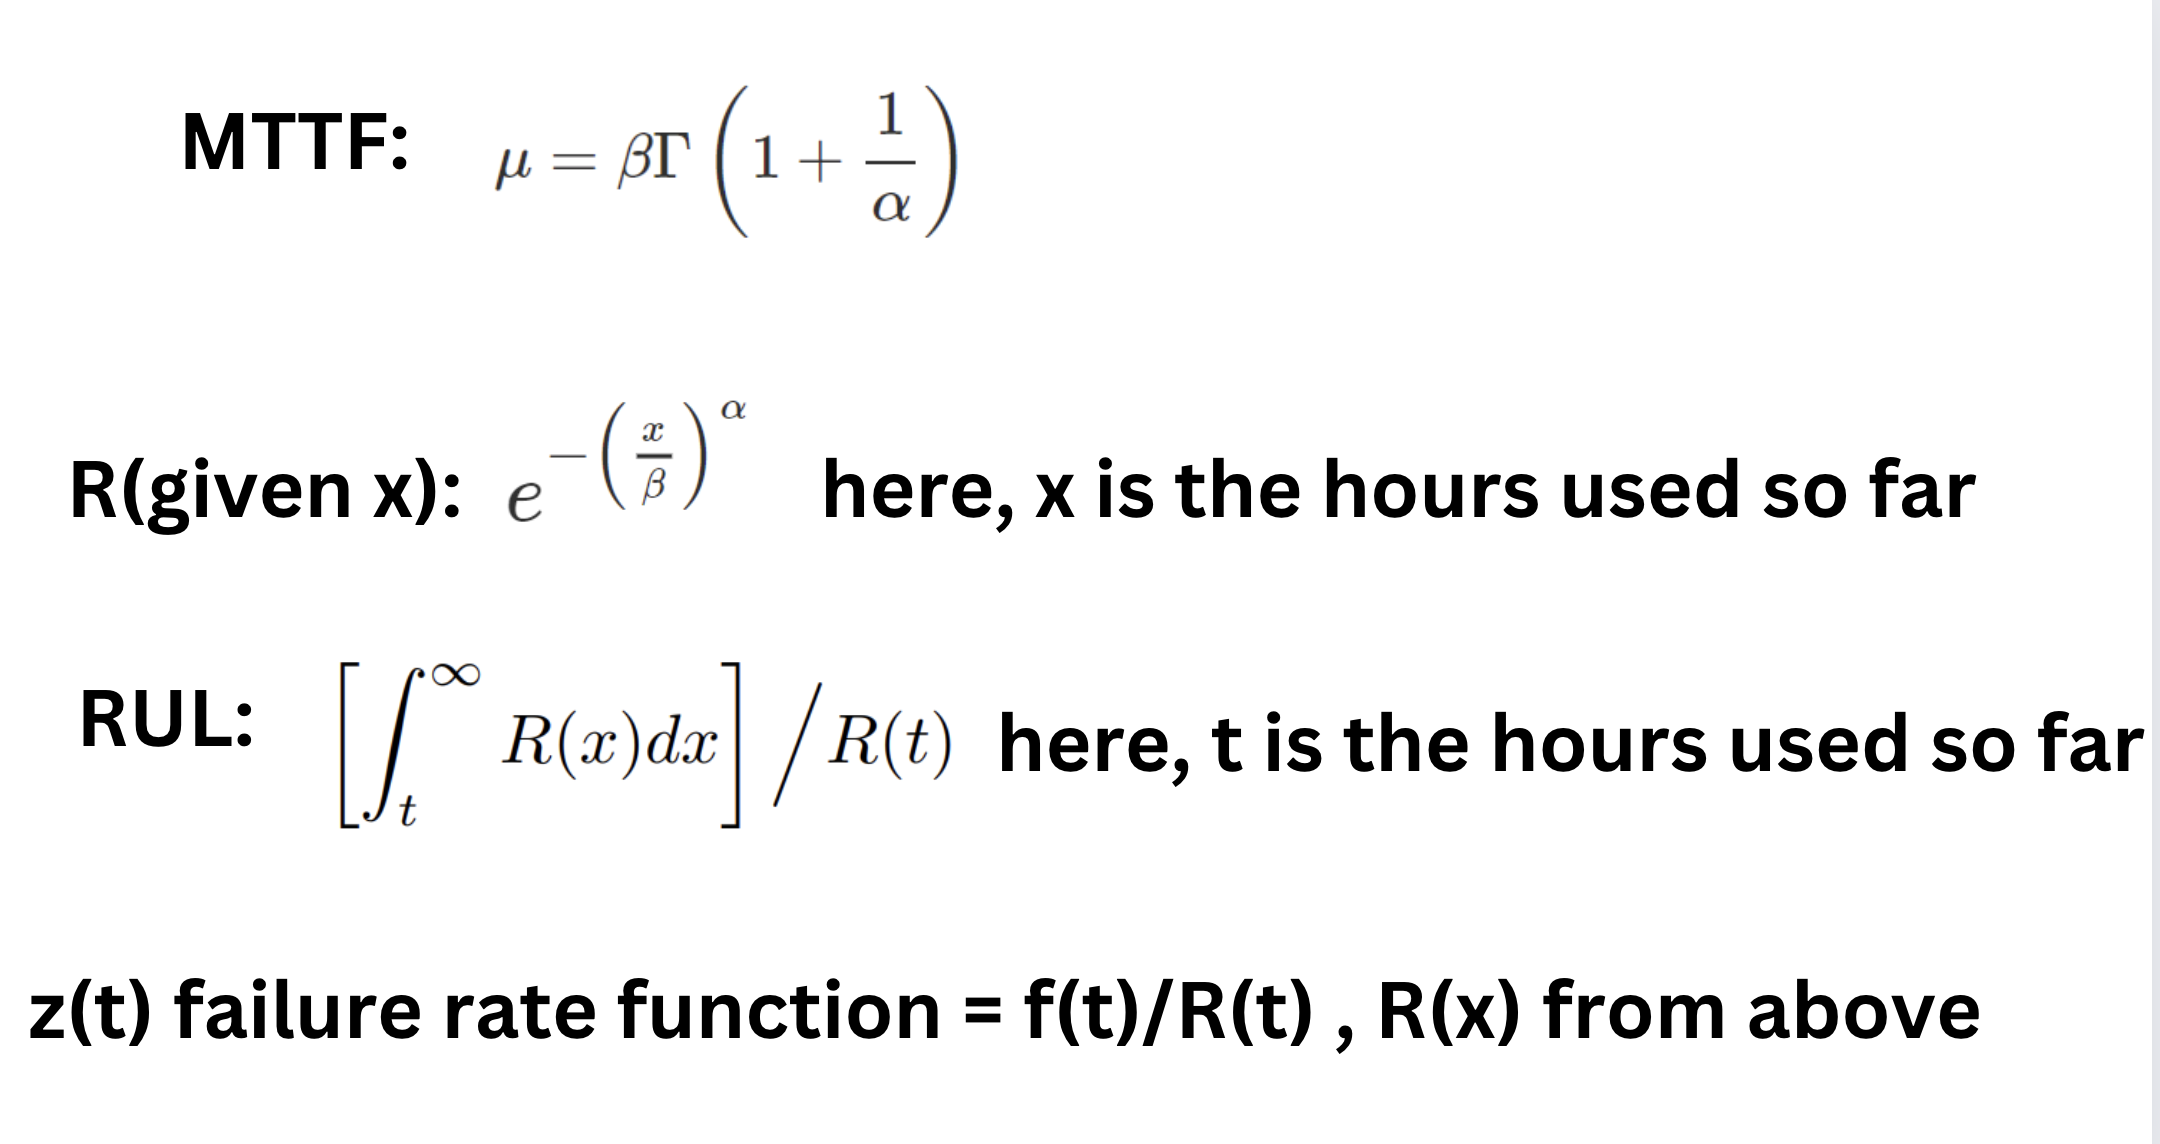

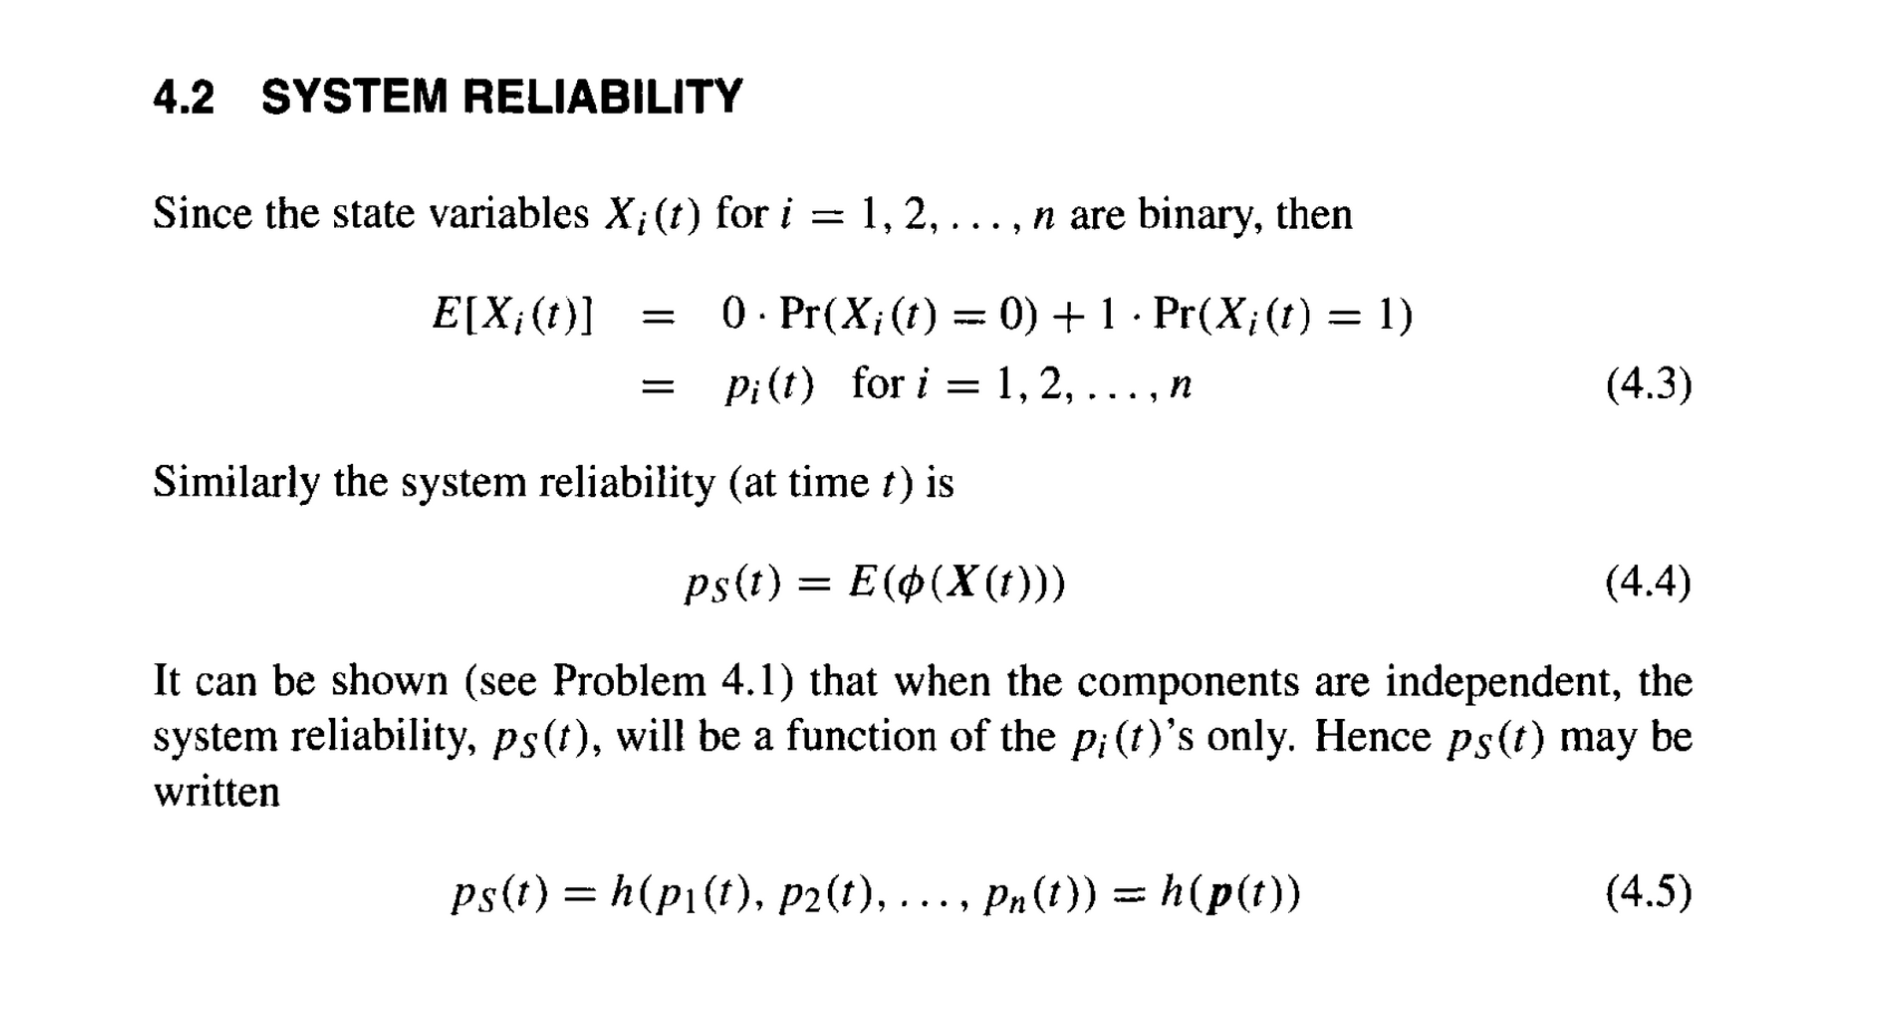

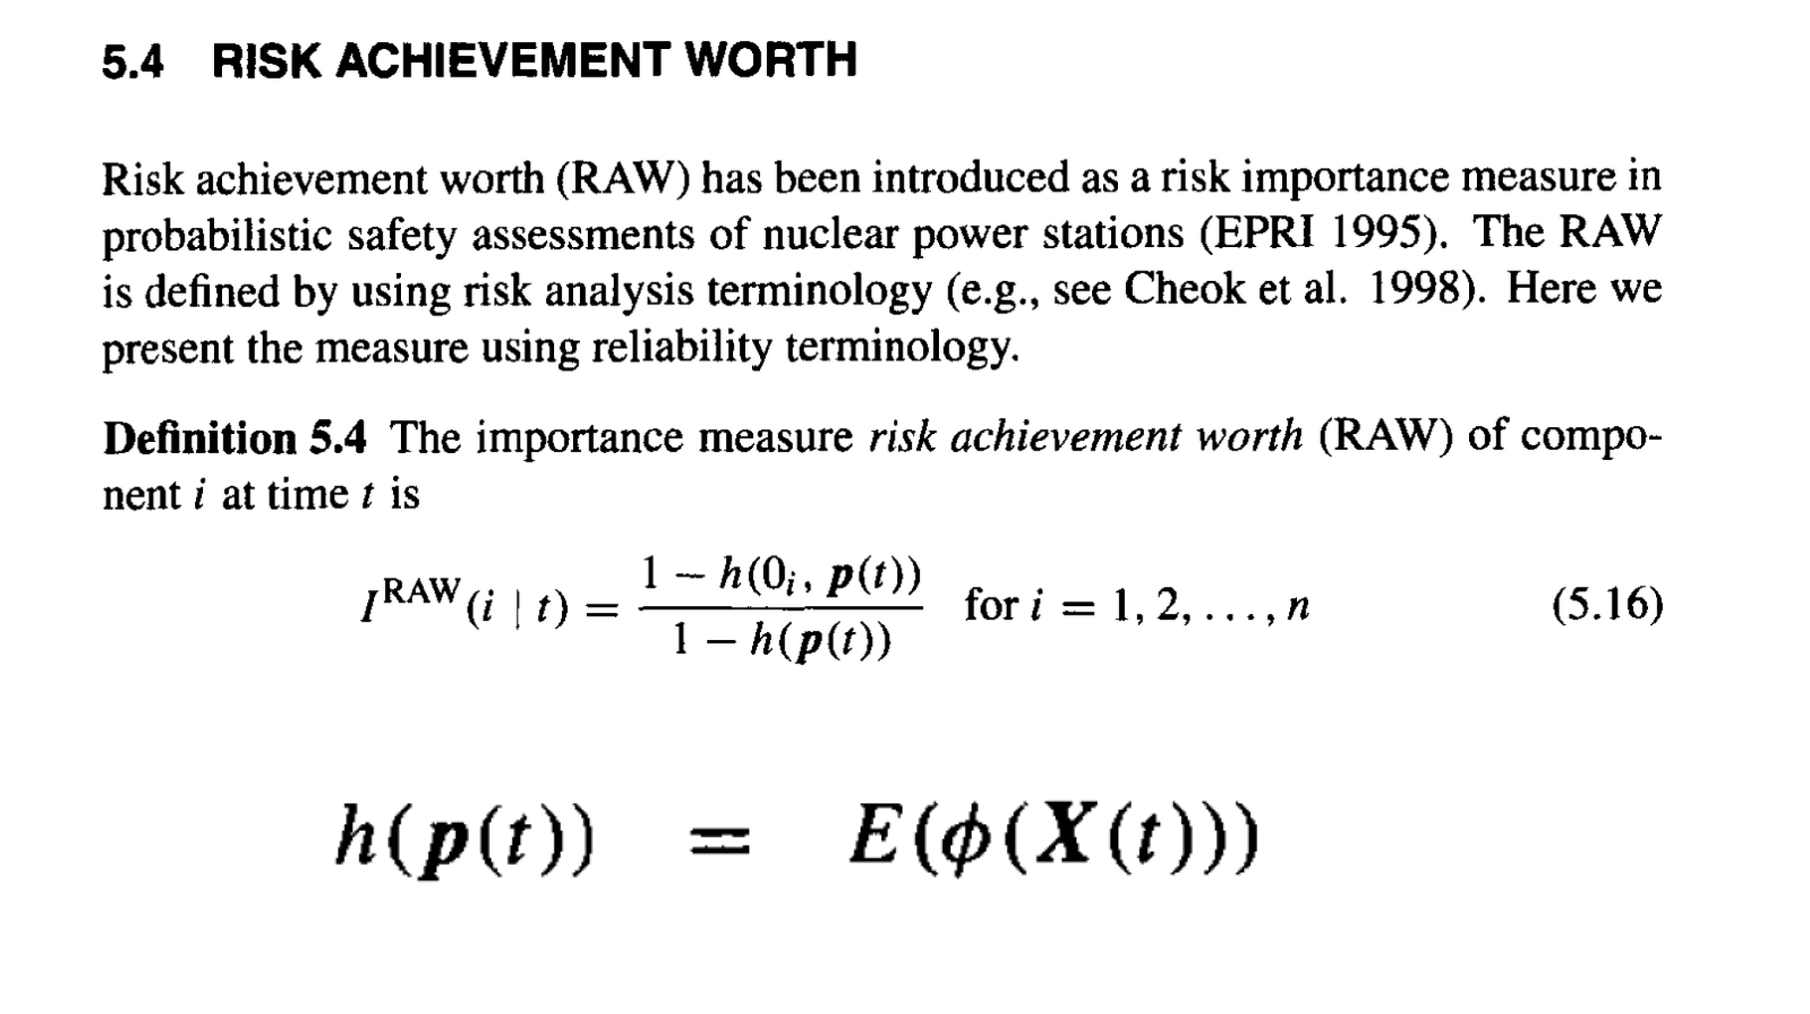

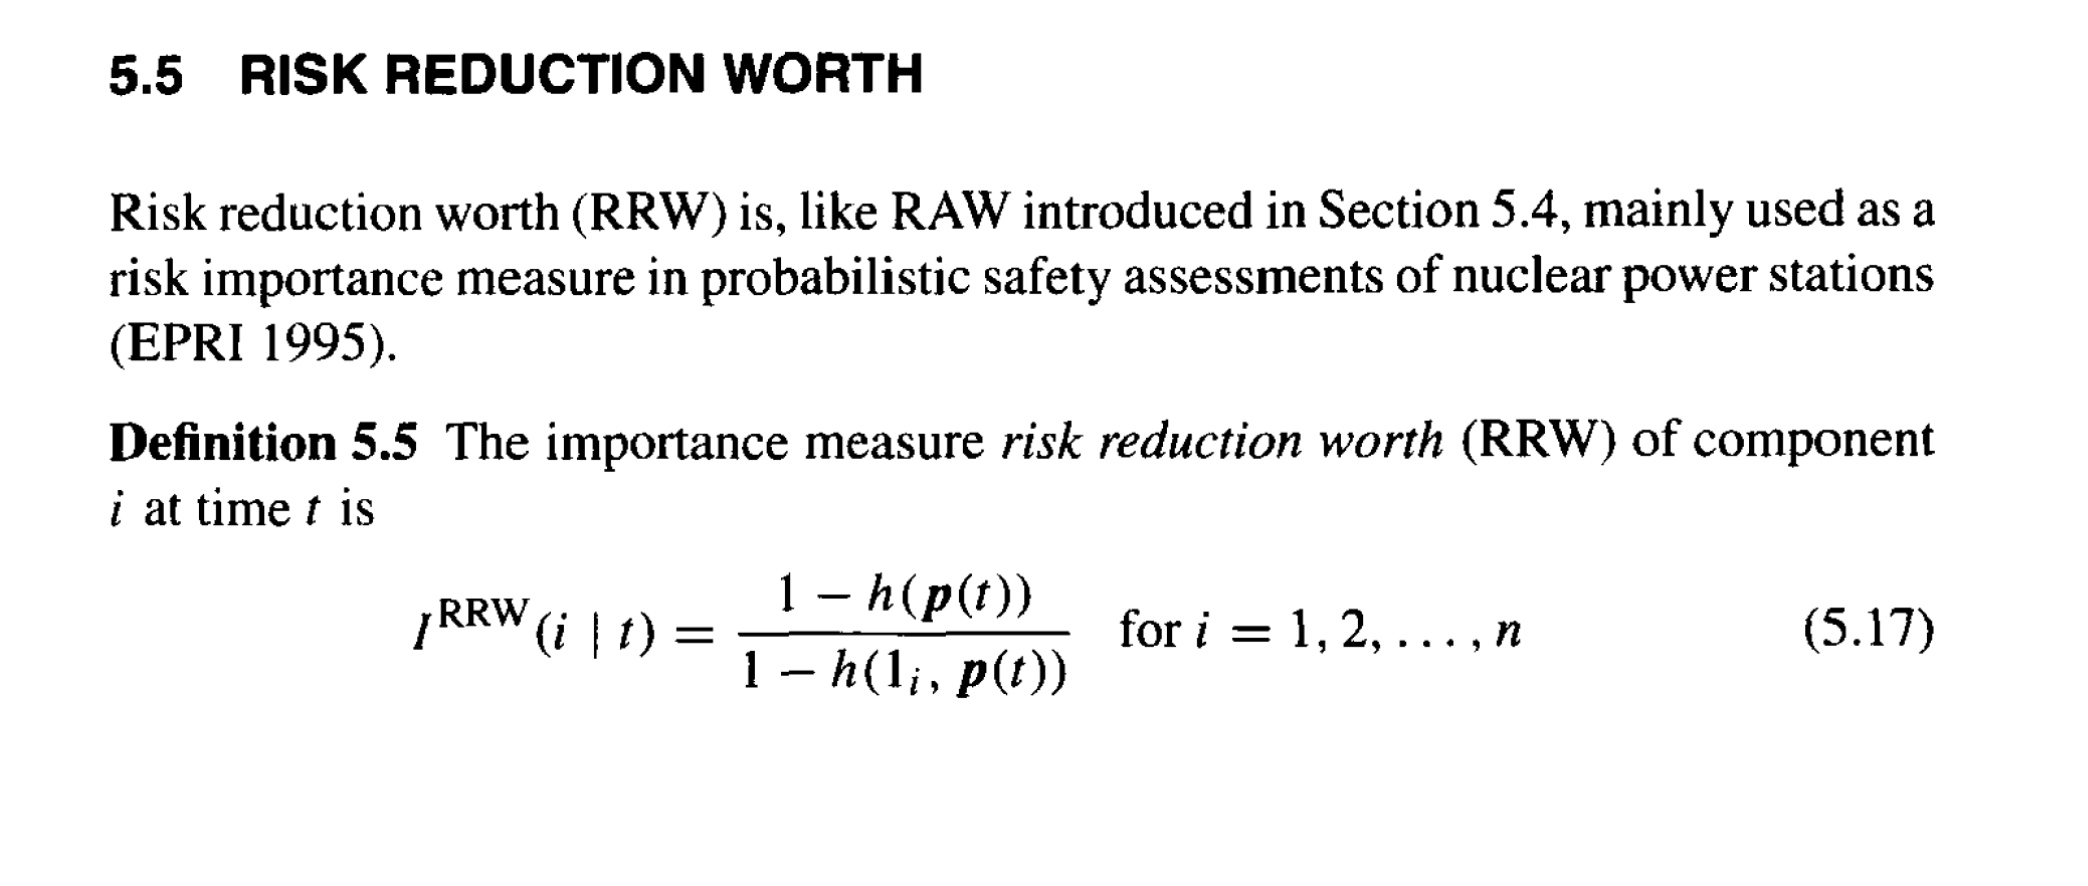